              
# Alphabet Sign Language Classification  

## `Pipeline Overview`
#### 1. Load & explore the ASL Alphabet dataset (87K images, 29 classes)
#### 2. Apply comprehensive data augmentation
#### 3. Build model using ResNet50 as feature extractor
#### 4. Two-phase training: frozen base → fine-tune top layers
#### 5. Save best weights with pickle
#### 6. Evaluate and visualize


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import libraries</p>

In [4]:
import os 
import cv2 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


import warnings
warnings.filterwarnings('ignore')

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Load The Dataset</p>

In [ ]:
data_dir='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
folders=os.listdir(data_dir)
image_paths = []
labels = []
for folder in folders:
    folder_path=os.path.join(data_dir,folder)
    images=os.listdir(folder_path)
    for img in images:
        img_path=os.path.join(folder_path,img)
        image_paths.append(img_path)
        labels.append(folder)

df=pd.DataFrame({'image_path': image_paths, 'label': labels})

In [6]:
df.shape


(87000, 2)

In [7]:
df.head()

image_path label
0  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
1  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
2  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
3  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
4  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N

In [8]:
class_count=df['label'].value_counts().to_frame()
class_count

count
label         
N         3000
R         3000
space     3000
B         3000
I         3000
del       3000
F         3000
H         3000
E         3000
U         3000
M         3000
X         3000
K         3000
Q         3000
Y         3000
S         3000
G         3000
A         3000
O         3000
T         3000
V         3000
Z         3000
C         3000
P         3000
L         3000
W         3000
D         3000
nothing   3000
J         3000

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">show image per class</p>

In [ ]:
unique_labels= df['label'].unique() 

num_classes = len(df['label'].unique()) # number classes

cols = 3  ## number images per row

rows = (num_classes // cols)+1  # number rows

plt.figure(figsize=(cols * 4, rows * 3))

for i, label in enumerate(unique_labels):
    # first image from each label 
    folder_path = os.path.join(data_dir, label)
    images = os.listdir(folder_path)
    img_name = images[0]
    full_path = os.path.join(folder_path, img_name)

    # convert to RGB
    img = cv2.imread(full_path) # open cv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">split data to train test and valid</p>

In [9]:
# Split the data into training and test sets (80% train, 20% valid)

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],  
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print(f'Train: {len(train_df):,} images ({len(train_df)/len(df)*100:.0f}%)')
print(f'Val:   {len(val_df):,} images ({len(val_df)/len(df)*100:.0f}%)')
print(f'Test:  {len(test_df):,} images ({len(test_df)/len(df)*100:.0f}%)')

Train: 69,600 images (80%)
Val:   8,700 images (10%)
Test:  8,700 images (10%)


## `Show Data Split Distribution`

In [16]:
data_split = {"split_data": [len(train_df), len(val_df), len(test_df)]}
df_split = pd.DataFrame(data_split, index=["train", "valid", "test"])

plt.figure(figsize=(6,6))
plt.pie(df_split["split_data"], 
        labels=df_split.index, 
        autopct='%1.1f%%',
        startangle=90)

plt.title("Data Split Distribution")
plt.axis('equal')    
plt.show()


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data Agumention</p>

In [29]:
IMG_SIZE = 224
BATCH_SIZE = 32


preprocess_input = tf.keras.applications.resnet50.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 69600 validated image filenames belonging to 29 classes.


In [30]:
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">ResNet50 Feature Extractor</p>

## `load model resnet50`

In [31]:
base_model=tf.keras.applications.ResNet50(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
) 
base_model.trainable=False

In [32]:
model = tf.keras.Sequential([
    base_model,  # Feature Extractor
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(29, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,853,725 (90.99 MB)

 Trainable params: 266,013 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## `callbacks`

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## `fit model`

In [50]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
epochs = 5
history_p1 = model.fit(train_generator, epochs=epochs, validation_data=val_generator,callbacks=[reduce_lr,early_stop])

Epoch 1/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 932s 421ms/step - accuracy: 0.9697 - loss: 0.1296 - val_accuracy: 0.9953 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 897s 412ms/step - accuracy: 0.9905 - loss: 0.0591 - val_accuracy: 0.9948 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 895s 412ms/step - accuracy: 0.9938 - loss: 0.0409 - val_accuracy: 0.9990 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 884s 407ms/step - accuracy: 0.9949 - loss: 0.0373 - val_accuracy: 0.9992 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 877s 403ms/step - accuracy: 0.9963 - loss: 0.0271 - val_accuracy: 0.9995 - val_loss: 0.0148 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [ ]:
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}") 
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Fine-Tunning Resnet50</p>

In [37]:
len(base_model.layers)

175

## `finetune & train`

In [38]:

# Unfreeze last 30 layer
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f'Trainable: {sum([1 for l in base_model.layers if l.trainable])} / {len(base_model.layers)} layers')

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_ft = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_model_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks_ft
)

Trainable: 30 / 175 layers
Epoch 1/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9013 - loss: 0.3463
Epoch 1: val_accuracy improved from -inf to 0.99598, saving model to best_model_finetuned.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 942s 425ms/step - accuracy: 0.9013 - loss: 0.3462 - val_accuracy: 0.9960 - val_loss: 0.0505 - learning_rate: 1.0000e-05
Epoch 2/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9795 - loss: 0.1011
Epoch 2: val_accuracy improved from 0.99598 to 0.99920, saving model to best_model_finetuned.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 900s 414ms/step - accuracy: 0.9795 - loss: 0.1011 - val_accuracy: 0.9992 - val_loss: 0.0360 - learning_rate: 1.0000e-05
Epoch 3/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9899 - loss: 0.0660
Epoch 3: val_accuracy did not improve from 0.99920
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 895s 411ms/step - accuracy: 0.9899 - loss: 0.0660 - val_accuracy: 0.9992 - val_loss: 0.0352 - learning_rate: 1.0000e-05
Epoc

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">show accuracy and loss of model </p>

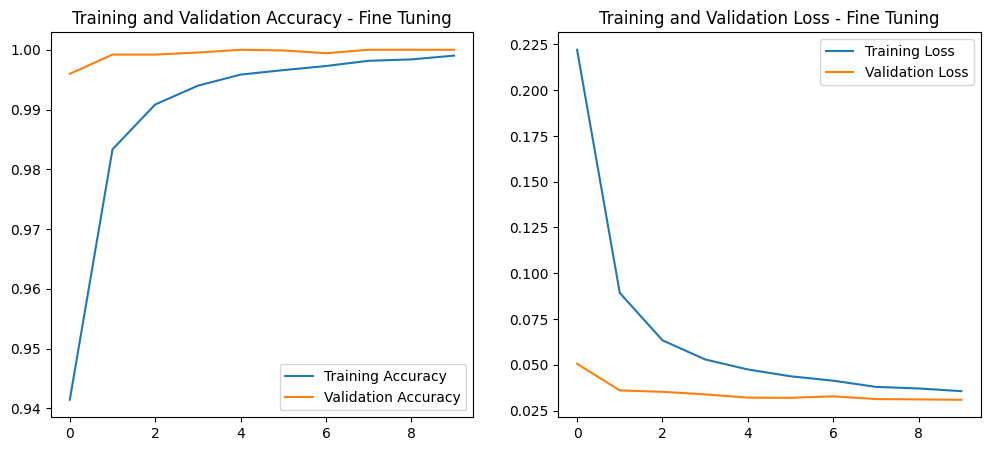

In [39]:
# Plot accuracy and loss curves
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - Fine Tuning')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - Fine Tuning')
plt.show()

In [40]:
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Evaluating model...
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 1.0000 - loss: 0.0324
Test Loss: 0.0324
Test Accuracy: 100.00%


In [41]:
model.save('asl_resnet50_final.keras')
print('Model saved!')

Model saved!


# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">evaluate model on test data</p>

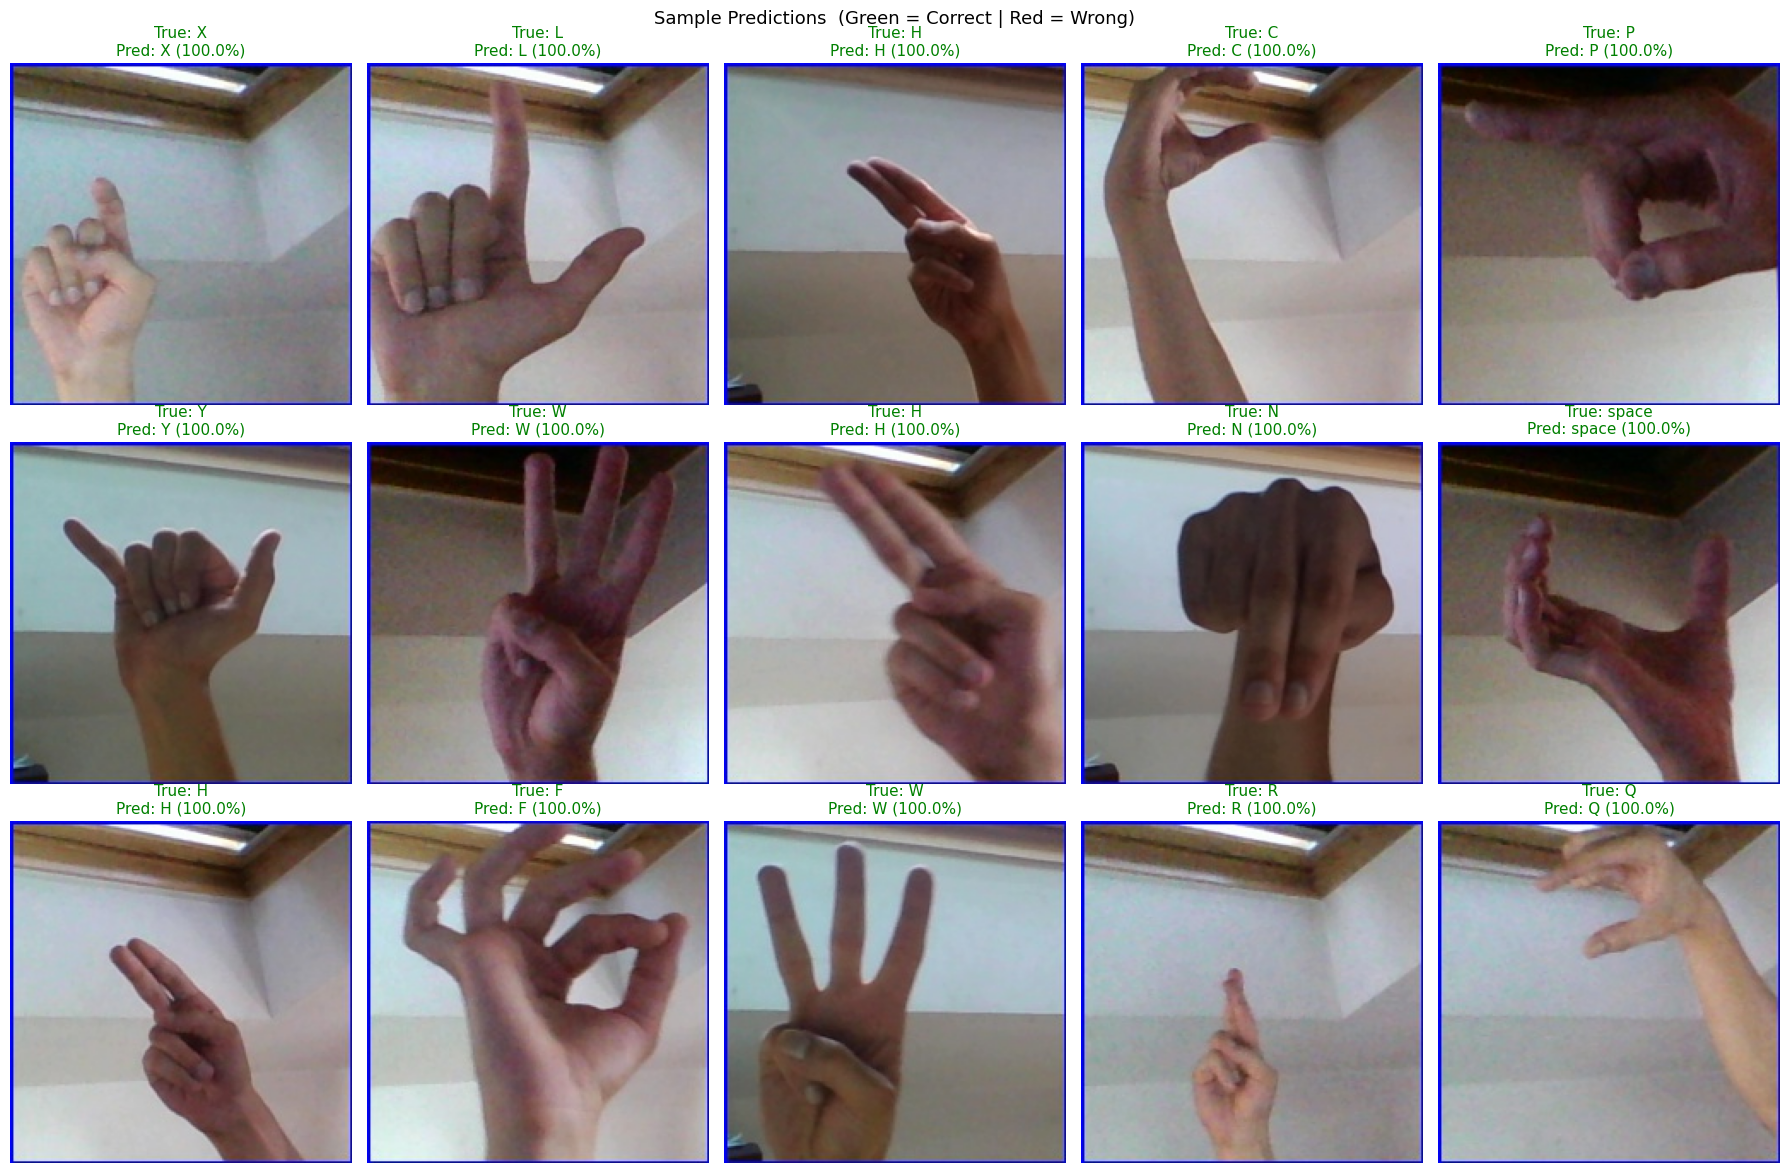

In [42]:
inv_class = {v: k for k, v in train_generator.class_indices.items()}
samples = test_df.sample(15, random_state=42)

fig, axes = plt.subplots(3, 5, figsize=(18, 12))

for idx, (_, row) in enumerate(samples.iterrows()):
    ax = axes[idx // 5][idx % 5]

    img = cv2.imread(row['image_path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    img_input = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_input = preprocess_input(img_input.astype(np.float32))
    img_input = np.expand_dims(img_input, axis=0)

    pred = model.predict(img_input, verbose=0)
    pred_class = inv_class[np.argmax(pred)]
    confidence = np.max(pred) * 100
    true_class = row['label']

    ax.imshow(img_rgb)  
    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)',
                 color=color, fontsize=11)
    ax.axis('off')

plt.suptitle('Sample Predictions  (Green = Correct | Red = Wrong)', fontsize=13)
plt.tight_layout()
plt.show()

# <p style="padding:10px;background-color: green ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">save model</p>

In [48]:
from IPython.display import FileLink

model.save('asl_resnet50_final.keras')
print('Model saved!')

FileLink('asl_resnet50_final.keras')

Model saved!


/kaggle/working/asl_resnet50_final.keras